In [ ]:
"""CLI entry point for SFC RL framework."""

import hydra
from omegaconf import DictConfig, OmegaConf, open_dict
from pathlib import Path
from datetime import datetime
import torch
from torch.utils.tensorboard import SummaryWriter  

import time
import shutil
import re 

from sfc_rl.data.dataset_provider import DatasetProvider
from sfc_rl.data.dataset_generator import Generator
from sfc_rl.env.sfc_env import SFCEnvRevised
from sfc_rl.env.state_encoders import NormalizedStateEncoder
from sfc_rl.env.action_space import NodeSelectionActionSpace
from sfc_rl.env.reward import QoE_QoS_Reward
from sfc_rl.env.qoe import QoE_QoS_PaperModel
from sfc_rl.models.dqn import DQNPolicy
from sfc_rl.models.networks import MLPPolicyNetwork
from sfc_rl.models.replay_buffer import ReplayBuffer
from sfc_rl.baselines.random_policy import RandomPolicy
from sfc_rl.baselines.exhaustive_solver import ExhaustiveSolver
from sfc_rl.train.trainer import TrainerRevised
from sfc_rl.train.evaluator import Evaluator
from sfc_rl.utils.seed import set_seed
from sfc_rl.utils.logging import setup_logger
from sfc_rl.utils.tensorboard import launch_tensorboard
#--------------------------------------------------------------------------------------------

config_path = "./../config"
config_name="experiment"


@hydra.main(version_base=None, config_path= config_path, config_name=config_name)
def main(cfg: DictConfig) -> None:
    
    """Main entry point.
    Args:
        cfg: Hydra configuration
    """

    # Set seed
    seed = cfg.get("seed", 42)
    set_seed(seed)
    
    # Create output directory
    output_dir = Path(f"{cfg.get('output_dir', 'outputs')}/{cfg.get('project_name', 'Ciriaa')}_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
    output_dir.mkdir(parents=True, exist_ok=True)
    # Setup logger
    logger = setup_logger("sfc_rl_test_data", log_file=output_dir / "run.log")
    logger.info(f"Starting experiment with config:\n{OmegaConf.to_yaml(cfg)}")
    
    # Save config
    OmegaConf.save(cfg, output_dir / "config.yaml")
    
    # Load dataset 
    # Merge data config into main config for Generator
    # When using Hydra defaults, cfg.data contains the merged config from data/synthetic_small.yaml
    with open_dict(cfg):
        if 'p_net_setting' not in cfg:
            # Check if p_net_setting is in cfg.data (from Hydra defaults)
            if hasattr(cfg, 'data') and cfg.data is not None:
                if hasattr(cfg.data, 'p_net_setting') and cfg.data.p_net_setting is not None:
                    cfg.p_net_setting = cfg.data.p_net_setting
                elif hasattr(cfg.data, 'get') and cfg.data.get('p_net_setting') is not None:
                    cfg.p_net_setting = cfg.data.get('p_net_setting')
        
        if 'v_sim_setting' not in cfg:
            # Check if v_sim_setting is in cfg.data (from Hydra defaults)
            if hasattr(cfg, 'data') and cfg.data is not None:
                if hasattr(cfg.data, 'v_sim_setting') and cfg.data.v_sim_setting is not None:
                    cfg.v_sim_setting = cfg.data.v_sim_setting
                elif hasattr(cfg.data, 'get') and cfg.data.get('v_sim_setting') is not None:
                    cfg.v_sim_setting = cfg.data.get('v_sim_setting')
    



    # Create dataset provider
    dataset_provider = DatasetProvider(cfg, logger)
    cache_path = Path(cfg.data.v_sim_setting.get('cache_path', '.vnReqs_cache'))

    if cache_path.exists() and cache_path.is_dir(): 
        shutil.rmtree(cache_path)
        logger.info(f"Cleaned and removed cache: {cache_path}")

    pn = dataset_provider.get_physical_network()
    vn_requests = dataset_provider.get_vn_requests()
    flag_pn = cfg.data.p_net_setting.get('dataset_dir',None) is not None
    flag_vn = cfg.data.v_sim_setting.get('dataset_dir',None) is not None
    logger.info(f"PN with {len(pn.nodes)} nodes and {len(pn.links)} links {'Loaded from path ' if flag_pn else 'Generated' }")
    logger.info(f" {len(vn_requests)} VN requests {'Loaded from path ' if flag_vn else 'Generated' }")

    if cfg.get('End_phase','All') == 'data' :
        if cache_path.exists() and cache_path.is_dir(): 
            shutil.rmtree(cache_path)
            logger.info(f"Cleaned and removed cache: {cache_path}")
        else:
            logger.info(f"Cache directory not found: {cache_path}")

        logger.info(f"Finishied")
        return
    
    #------------------------------- Env------------------------------------

    num_groups = cfg.data.v_sim_setting.get('num_groups')

    # Create environment components
    env_cfg = cfg.env
    
    # State encoder
    state_encoder_type = env_cfg.state.get("encoder", "NormalizedStateEncoder")
    if state_encoder_type == "NormalizedStateEncoder":
        state_encoder = NormalizedStateEncoder(env_cfg.state.get("encoder_config", {}))
    else:
        raise ValueError(f"Unknown encoder type: {state_encoder_type}")
    state_dim = state_encoder.get_state_dim(pn)
    
    # Action space
    action_space = NodeSelectionActionSpace(
        mask_illegal=env_cfg.action.get("mask_illegal", True)
    )
    action_dim = action_space.get_action_dim(pn)
    
    # QoE model
    qoe_cfg = env_cfg.qoe_model
    if qoe_cfg.name == "qoe_qos_paper":
        qoe_model = QoE_QoS_PaperModel(qoe_cfg.get("config", {}))
    else:
        raise ValueError(f"Unknown QoE model: {qoe_cfg.name}")
    
    # Reward function
    #reward_fn = TerminalQoEReward(qoe_model, env_cfg.reward)
    reward_fn = QoE_QoS_Reward(qoe_model, env_cfg.reward)
    
    # Create environment
    env = SFCEnvRevised(
        pn=pn,
        vn_requests=vn_requests,
        num_groups=num_groups,
        state_encoder=state_encoder,
        action_space=action_space,
        reward_fn=reward_fn,
        qoe_model=qoe_model,
        max_steps_per_request=cfg.train.get("max_steps_per_episode", 2000),
    )
    



    #------------------------------------- Policy --------------------------------

    
    # Create policy
    model_cfg = cfg.model
    if model_cfg.type == "dqn":

        # Create network
        network_cfg = model_cfg.network
        network = MLPPolicyNetwork(
            state_dim=state_dim,
            action_dim=action_dim,
            hidden_sizes=network_cfg.hidden_sizes,
            activation=network_cfg.activation,
            dueling=model_cfg.dqn.get("dueling", False),
        )
        
        # Create DQN policy
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        policy = DQNPolicy(
            state_dim=state_dim,
            action_dim=action_dim,
            network=network,
            config=model_cfg,
            device=device,
        )
        logger.info(f"Created DQN policy on {device}")
    elif model_cfg.type == "random":
        policy = RandomPolicy(cfg.get("seed", 42))
    elif model_cfg.type == 'Violent':
        policy = ExhaustiveSolver( max_embeddings=1000000, seed = cfg.get("seed", 42))
    else:
        raise ValueError(f"Unknown model type: {model_cfg.type}")
    

    import random 
    random.Random(
    #------------------------------------- Train -----------------------------------------

    from scipy import interpolate
    from sfc_rl.train.plots import plot_training_curves

    tensorboard_use = False

    if tensorboard_use:

        tb_writer = SummaryWriter(log_dir=str(output_dir / "tensorboard"))
        tb_process = launch_tensorboard(output_dir / "tensorboard")
        logger.info("launching Tensorboard...")

        time.sleep(5)


    num_trains = 2
    grps_permutation_seeds = np.random.randint(1,50,num_trains).tolist()
    grps_permutation_seeds[0]= None

    RESULTS = []
    LOSSES = []

    # Train
    train_cfg = cfg.train
    if train_cfg.get('train', True): #or getattr(train_cfg, 'train', True):

        for tr in range(num_trains):
            env.grps_permutation_seed = grps_permutation_seeds[tr]
            trainer = TrainerRevised(
                env=env,
                policy=policy,
                config=train_cfg,
                output_dir=output_dir,
                summarywriter=tb_writer if tensorboard_use else None,
                logger=logger,
                tensorboard_use=tensorboard_use,
            )

            logger.info(f"Starting training loop {tr + 1}...")
            results, losses = trainer.train()

            for i in results.keys():
                if 'mean_episode_length' in results[i]:
                    del results[i]['mean_episode_length']

            print(f'{'#\n' * 10}')
            logger.info(f"Training completed. Final metrics:")
            for episode, metric in results.items():
                #print(f'Episode {episode}: {metric} \n' )
                logger.info(f'Episode {episode}: {metric} \n')
            qoes=[results[i]['qoe'] for i in results.keys()]
            RESULTS.append(qoes)
            LOSSES.append(losses)


        averaged_qoes = np.mean(RESULTS, axis=0)
        loss_interpolated = []

        num_episodes = len(RESULTS[0])
        resolution_loss =  np.max([len(loss) for loss in LOSSES])
        print('loss_interpolated: ',resolution_loss)

        x_arrays = [np.linspace(0,num_episodes,len(loss)) for loss in LOSSES]
        x_common_loss = np.linspace(0, num_episodes , resolution_loss)  # Higher resolution than any input

        # Interpolate each dataset to common grid
        y_interpolated = []
        for x_orig, loss_orig in zip(x_arrays, LOSSES):
            # Create interpolation function
            interp_func = interpolate.interp1d(
                x_orig, loss_orig,
                kind='linear',  # or 'cubic', 'quadratic'
                bounds_error=False,
                fill_value='extrapolate'  # or specific value
            )
            # Evaluate on common grid
            loss_interpolated.append(interp_func(x_common_loss))

        # Average the interpolated values
        loss_avg = np.mean(loss_interpolated, axis=0)
        loss_std = np.std(loss_interpolated, axis=0)  # Optional: standard deviation





        plot_training_curves(rewards=averaged_qoes, losses= loss_avg,output_dir = output_dir / "training plots", filename=f"averaged_QoE_Loss_for_{num_trains}-time-training.png", window=5,episode=num_episodes,run_in_notebook=train_cfg.run_in_notebook)


    else:
        logger.info("training Skipped...")


    #------------------------------------- Load Best Model and Evaluate --------------------------------------


    eval_cfg = cfg.eval

    if eval_cfg.get('enabled', True):

        logger.info(f"Loading most recent model ")

        checkpoint_files = list(output_dir.glob("checkpoint_ep*.pt"))
        checkpoints = sorted(
            checkpoint_files,
            key=lambda x: int(re.search(r"checkpoint_ep(\d+)\.pt", x.name).group(1))
            )   
            
        

        if checkpoints:
            trained_policy = DQNPolicy(
                state_dim=policy.state_dim,
                action_dim=policy.action_dim,
                network=policy.q_network,
                config=policy.config,
                device=policy.device
            )
            trained_policy.load(str(checkpoints[-1]))
            trained_policy.q_network.eval()
            trained_policy.target_network.eval()
            logger.info(f"Successfully loaded the most recent model")
        else:
            logger.warning(f"No checkpoints found. ")
            # Fallback to latest checkpoint or current policy
            checkpoint_files = list(output_dir.glob("checkpoint_ep*.pt"))
            if checkpoint_files:
                latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.stem.split('_ep')[-1]))
                trained_policy = DQNPolicy(
                    state_dim=policy.state_dim,
                    action_dim=policy.action_dim,
                    network=policy.q_network,
                    config=policy.config,
                    device=policy.device
                )
                trained_policy.load(str(latest_checkpoint))
                trained_policy.q_network.eval()
                trained_policy.target_network.eval()
            else:
                trained_policy = policy
                trained_policy.q_network.eval()
                trained_policy.target_network.eval()


        #-------------------- Evaluate ----------------------

        logger.info("Starting Evaluating...")
        evaluator = Evaluator(env,
        policies={'random':RandomPolicy(model_cfg.get("seed", 42)),'dqn':trained_policy,'violent':ExhaustiveSolver( max_embeddings=1000000, seed = model_cfg.get("seed", 42))},
        config=eval_cfg, output_dir= output_dir / Path(eval_cfg.get('output_dir','output_eval')),logger = logger)

        evaluator.evaluate()

        logger.info(f"Experiment completed. Results saved to {output_dir / Path(eval_cfg.get('output_dir','output_eval')) }")
        if cache_path.exists() and cache_path.is_dir(): 
            shutil.rmtree(cache_path)
            logger.info(f"Cleaned and removed cache: {cache_path}")
        else:
            logger.info(f"Cache directory not found: {cache_path}")

    else :
        logger.info(" Evaluating skipped...")
        if cache_path.exists() and cache_path.is_dir(): 
            shutil.rmtree(cache_path)
            logger.info(f"Cleaned and removed cache: {cache_path}")
        else:
            logger.info(f"Cache directory not found: {cache_path}")

    if tensorboard_use:
        if tb_process:
            tb_process.terminate()
            print("TensorBoard stopped.")


main()



#python -m sfc_rl.cli data.v_sim_setting.num_groups=15 model.dqn.eps_decay_steps=1500 project_name=after_hashemi3


#Tasks to do:
#1- verify DQN , go watch some videos tutorials and ... of dqn implementation 1h
#2- use it in jupyter lab/ notebook (refactor its form if needed) 1-2h
#3- run for 500 episodes or sth 3-4 h
#4 - report to Hashemi 1h

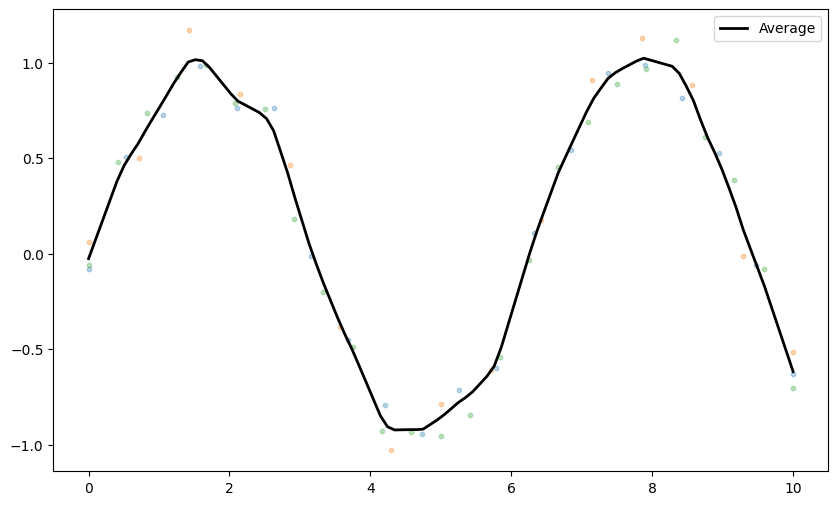

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Example data
x_arrays = [
    np.linspace(0, 10, 20),
    np.linspace(0, 10, 15),
    np.linspace(0, 10, 25)
]

y_arrays = [
    np.sin(x_arrays[0]) + np.random.normal(0, 0.1, len(x_arrays[0])),
    np.sin(x_arrays[1]) + np.random.normal(0, 0.1, len(x_arrays[1])),
    np.sin(x_arrays[2]) + np.random.normal(0, 0.1, len(x_arrays[2]))
]

# Create a common x-grid (choose resolution based on your needs)
x_common = np.linspace(0, 10, 100)  # Higher resolution than any input

# Interpolate each dataset to common grid
y_interpolated = []
for x_orig, y_orig in zip(x_arrays, y_arrays):
    # Create interpolation function
    interp_func = interpolate.interp1d(
        x_orig, y_orig,
        kind='linear',  # or 'cubic', 'quadratic'
        bounds_error=False,
        fill_value='extrapolate'  # or specific value
    )
    # Evaluate on common grid
    y_interpolated.append(interp_func(x_common))

# Average the interpolated values
y_avg = np.mean(y_interpolated, axis=0)
y_std = np.std(y_interpolated, axis=0)  # Optional: standard deviation

# Plot
plt.figure(figsize=(10, 6))
for x, y in zip(x_arrays, y_arrays):
    plt.scatter(x, y, alpha=0.3, s=10)
plt.plot(x_common, y_avg, 'k-', linewidth=2, label='Average')
#plt.fill_between(x_common, y_avg - y_std, y_avg + y_std, alpha=0.3)
plt.legend()
plt.show()

In [9]:
import random
import functools

def index_randommap_simple(index, range_tuple, seed):
    """Simple version without caching"""
    lower, upper = range_tuple
    
    if not (lower <= index < upper):
        raise ValueError(f"Index {index} not in range [{lower}, {upper})")
    
    n = upper - lower
    if n <= 1:
        return index
    
    # Generate permutation on the fly
    indices = list(range(n))
    random.Random(seed).shuffle(indices)
    
    return indices[index - lower] + lower




index_randommap_simple(5,(0,7),42)

0

In [54]:
import numpy as np
from typing import Optional

def index_randommap_simple(index:int, range_tuple: tuple, seed: Optional[int]=None):
    """Simple version without caching"""
    lower, upper = range_tuple
    
    if not (lower <= index < upper):
        raise ValueError(f"Index {index} not in range [{lower}, {upper})")
    
    n = upper - lower
    if n <= 1 or seed==None:
        return index
    
    # Generate permutation on the fly
    indices = list(range(n))
    rng = np.random.RandomState(seed)  # Creates seeded NumPy RNG
    rng.shuffle(indices)  # Shuffles in-place    

    print(indices)
    return indices[index - lower] + lower
    




index_randommap_simple(5,(0,7),15)

[3, 2, 6, 1, 4, 5, 0]


5

In [47]:

index_randommap_simple(2,(0,7),42)

[0, 1, 5, 2, 4, 3, 6]


5

In [49]:
index_randommap_simple(6,(0,7),42)


[0, 1, 5, 2, 4, 3, 6]


6

In [57]:
index_randommap_simple(4,(0,7))


4

In [65]:
import numpy as np

x = [1, 2, 3, 4, 5]
print(f"Original: {x}")

# Convert to numpy array
x_np = np.array(x)
x_np = x

# Shuffle in-place
rng = np.random.RandomState(42)
rng.shuffle(x_np)

# Convert back to list if needed
#x = x_np.tolist()
print(f"NumPy shuffled: {x}")  # [3, 4, 0, 1, 2] (note: indices if using arange)

Original: [1, 2, 3, 4, 5]
NumPy shuffled: [2, 5, 3, 1, 4]


In [1]:
!git status

On branch main
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Thesis-RL-Notebook.ipynb
	modified:   sfc_rl/train/plots.py

no changes added to commit (use "git add" and/or "git commit -a")


In [2]:
!git add sfc_rl/train/plots.py Thesis-RL-Notebook.ipynb


In [3]:
!git commit -m "training loop and shuffle added"
!git push origin main


[main faa30be] training loop and shuffle added
 2 files changed, 65 insertions(+), 45 deletions(-)
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 8 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.37 KiB | 1.37 MiB/s, done.
Total 6 (delta 5), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To github.com:Mehrabpsh/Thesis-Smart-Slicing-rl-revised.git
   a2defc4..faa30be  main -> main


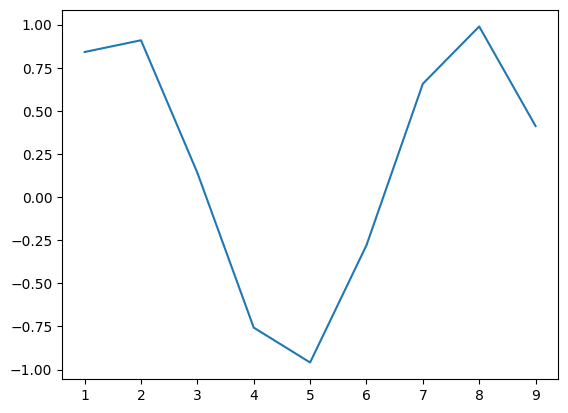

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(1,10),np.sin(range(1,10)))